In [ ]:
# IMPORT LIBRARIES
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings('ignore')

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


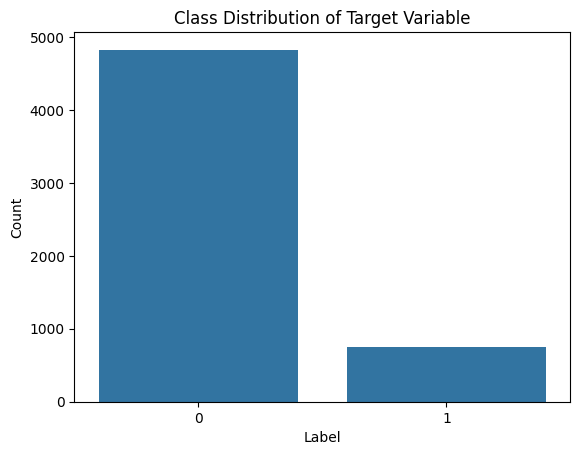

In [ ]:
# LOAD THE DATA
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
print(data.head())

# Remove unnecessary columns
df = data[['v1', 'v2']]

# Rename the columns
df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)

# Encode labels ('ham' as 0 and 'spam' as 1)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])


# Visualize the class distribution
sns.countplot(x='label', data=df)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution of Target Variable')
plt.show()

In [ ]:
# Text Normalization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['message'] = df['message'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenization and padding of the text
max_words = 10000  # Maximum number of words to keep in the vocabulary
max_len = 100      # Maximum sequence length for each message

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['message'])

# Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(df['message'])

# Pad sequences to the same length
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Build the RNN model
RNNmodel = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


RNNmodel.build(input_shape=(None, max_len))
RNNmodel.summary()


lr = 0.001
# Compile the model
RNNmodel.compile(optimizer=Adam(learning_rate = lr), loss='binary_crossentropy', metrics=['accuracy'])


# Train the model using the resampled data
RNNhistory = RNNmodel.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, RNNaccuracy = RNNmodel.evaluate(X_test, y_test)
print(f'Test Accuracy: {RNNaccuracy:.4f}')



# Build the LSTM model
LSTMmodel = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(34, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


LSTMmodel.build(input_shape=(None, max_len))
LSTMmodel.summary()


lr = 0.001
# Compile the model
LSTMmodel.compile(optimizer=Adam(learning_rate = lr), loss='binary_crossentropy', metrics=['accuracy'])


# Train the model using the resampled data
LSTMhistory= LSTMmodel.fit(X_train_res, y_train_res, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, LSTMaccuracy = LSTMmodel.evaluate(X_test, y_test)
print(f'Test Accuracy: {LSTMaccuracy:.4f}')

# Show example results
def show_example_results(model, X_test, y_test, num_examples=10):
    predictions = (model.predict(X_test) > 0.5).astype("int32")
    for i in range(num_examples):
        print(f'Example {i + 1}:')
        print(f'Message: {X_test[i]}')  # This is the padded sequence
        print(f'Predicted: {"spam" if predictions[i] == 1 else "ham"}')
        print(f'Actual: {"spam" if y_test.iloc[i] == 1 else "ham"}\n')

print("\nExample Results for RNN Model:")
show_example_results(RNNmodel, X_test, y_test)

print("\nExample Results for LSTM Model:")
show_example_results(LSTMmodel, X_test, y_test)



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 100, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 64)                  │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 328,321 (1.25 MB)

 Trainable params: 328,321 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.7804 - loss: 0.4635 - val_accuracy: 0.9130 - val_loss: 0.2306
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9512 - loss: 0.1377 - val_accuracy: 0.9354 - val_loss: 0.1887
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9876 - loss: 0.0373 - val_accuracy: 0.9480 - val_loss: 0.1681
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.9981 - loss: 0.0060 - val_accuracy: 0.9327 - val_loss: 0.2295
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9552 - val_loss: 0.1861
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 1.0000 - loss: 2.5084e-04 - val_accuracy: 0.9561 - val_loss: 0.1888
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 1.0000 - loss: 1.5317e-04 - val_accuracy: 0.9534 - val_loss: 0.2263
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 1.0000 - loss: 9.9794

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, 100, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 34)                  │           9,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           1,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 330,265 (1.26 MB)

 Trainable params: 330,265 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.8429 - loss: 0.4333 - val_accuracy: 0.9659 - val_loss: 0.1275
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9733 - loss: 0.0847 - val_accuracy: 0.9381 - val_loss: 0.2014
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.9886 - loss: 0.0419 - val_accuracy: 0.9525 - val_loss: 0.1783
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9945 - loss: 0.0205 - val_accuracy: 0.9570 - val_loss: 0.1918
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9982 - loss: 0.0083 - val_accuracy: 0.9578 - val_loss: 0.1666
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.9986 - loss: 0.0052 - val_accuracy: 0.9722 - val_loss: 0.1794
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9988 - loss: 0.0037 - val_accuracy: 0.9247 - val_loss: 0.4021
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9998 - loss: 0.0012 - 

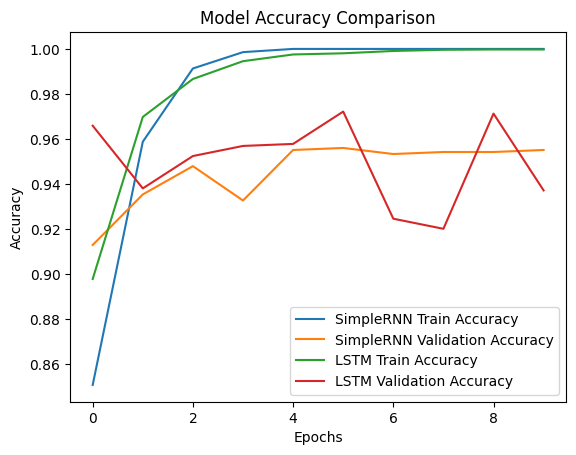

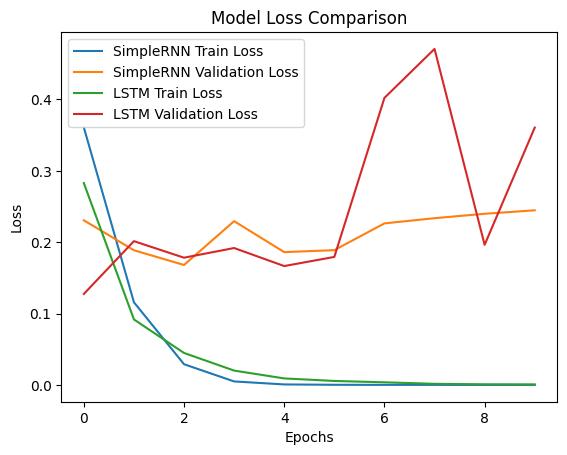

In [ ]:
# Plot training & validation accuracy for both models
plt.plot(RNNhistory.history['accuracy'], label='SimpleRNN Train Accuracy')
plt.plot(RNNhistory.history['val_accuracy'], label='SimpleRNN Validation Accuracy')
plt.plot(LSTMhistory.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(LSTMhistory.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss for both models
plt.plot(RNNhistory.history['loss'], label='SimpleRNN Train Loss')
plt.plot(RNNhistory.history['val_loss'], label='SimpleRNN Validation Loss')
plt.plot(LSTMhistory.history['loss'], label='LSTM Train Loss')
plt.plot(LSTMhistory.history['val_loss'], label='LSTM Validation Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()